In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pandas as pd

Load data

In [3]:
X_img = np.load("../data/satellite_patches_training.npy")
Y = np.load("../data/species_data_training.npy")
env = pd.read_csv("../data/env_variables_training.csv")
ts = pd.read_csv("../data/landsat_timeseries_training.csv")
X_img_te = np.load("../data/satellite_patches_test.npy")
Y_te     = np.load("../data/species_data_test.npy")
env_te   = pd.read_csv("../data/env_variables_test.csv")
ts_te    = pd.read_csv("../data/landsat_timeseries_test.csv")

Simple model for testing purposes

In [4]:
# Use climate variables only for testing purposes
bio_cols = [c for c in env.columns if c.startswith("Bio")]
X_tr = torch.tensor(env[bio_cols].to_numpy(), dtype=torch.float32) 
Y_tr = torch.tensor(Y, dtype=torch.float32)

X_te = torch.tensor(env_te[bio_cols].to_numpy(), dtype=torch.float32)
Y_te = torch.tensor(Y_te, dtype=torch.float32)

class SimpleMLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        return self.fc(x) 

# visualize data

X_img: (5000, 3, 128, 128) uint8
Y: (5000, 342) int64
env: (5000, 22)
ts: (5000, 161)
env columns: ['surveyId', 'lon', 'lat', 'Bio1', 'Bio2', 'Bio3', 'Bio4', 'Bio5', 'Bio6', 'Bio7', 'Bio8', 'Bio9', 'Bio10', 'Bio11', 'Bio12', 'Bio13', 'Bio14', 'Bio15', 'Bio16', 'Bio17']
ts columns: ['surveyId', 'landsat_red_2008_1', 'landsat_red_2008_2', 'landsat_red_2008_3', 'landsat_red_2008_4', 'landsat_red_2009_1', 'landsat_red_2009_2', 'landsat_red_2009_3', 'landsat_red_2009_4', 'landsat_red_2010_1', 'landsat_red_2010_2', 'landsat_red_2010_3', 'landsat_red_2010_4', 'landsat_red_2011_1', 'landsat_red_2011_2', 'landsat_red_2011_3', 'landsat_red_2011_4', 'landsat_red_2012_1', 'landsat_red_2012_2', 'landsat_red_2012_3', 'landsat_red_2012_4', 'landsat_red_2013_1', 'landsat_red_2013_2', 'landsat_red_2013_3', 'landsat_red_2013_4', 'landsat_red_2014_1', 'landsat_red_2014_2', 'landsat_red_2014_3', 'landsat_red_2014_4', 'landsat_red_2015_1']
N, C, H, W: 5000 3 128 128


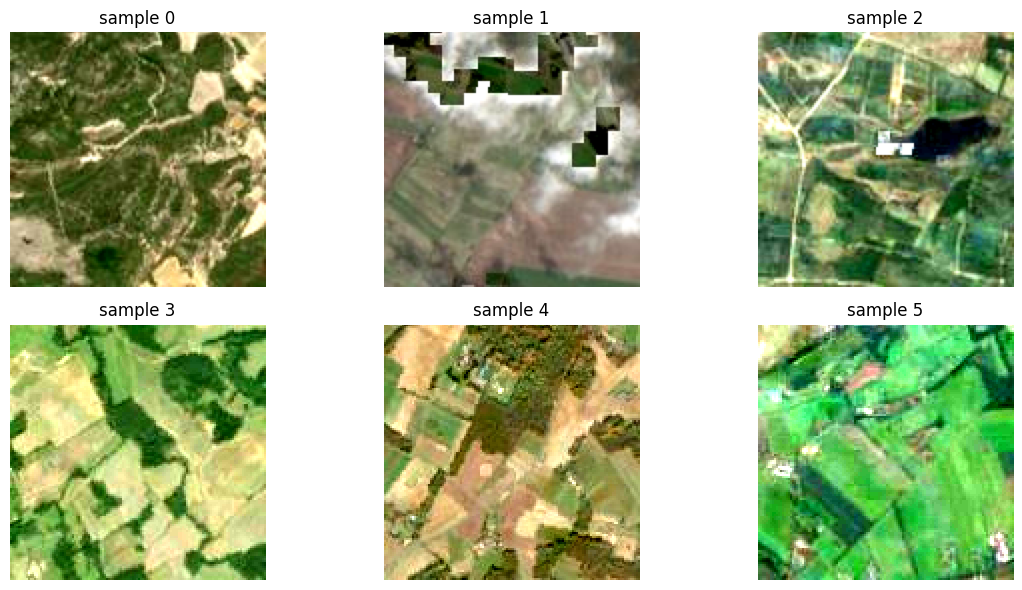

In [5]:

print("X_img:", X_img.shape, X_img.dtype)
print("Y:", Y.shape, Y.dtype)
print("env:", env.shape)
print("ts:", ts.shape)
print("env columns:", list(env.columns)[:20])
print("ts columns:", list(ts.columns)[:30])

N, C, H, W = X_img.shape
print("N, C, H, W:", N, C, H, W)

def chw_to_hwc(img):
    # if (3,H,W) -> (H,W,3)
    if img.ndim == 3 and img.shape[0] == 3:
        return np.transpose(img, (1,2,0))
    return img

def norm01(img):
    img = img.astype(np.float32)
    lo, hi = np.percentile(img, 2), np.percentile(img, 98)
    if hi > lo:
        img = (img - lo) / (hi - lo)
    return np.clip(img, 0, 1)

idxs = [0, 1, 2, 3, 4, 5]
plt.figure(figsize=(12,6))

for i, idx in enumerate(idxs, 1):
    img = norm01(chw_to_hwc(X_img[idx]))
    ax = plt.subplot(2, 3, i)
    ax.imshow(img)
    ax.set_title(f"sample {idx}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Analyse Labels 


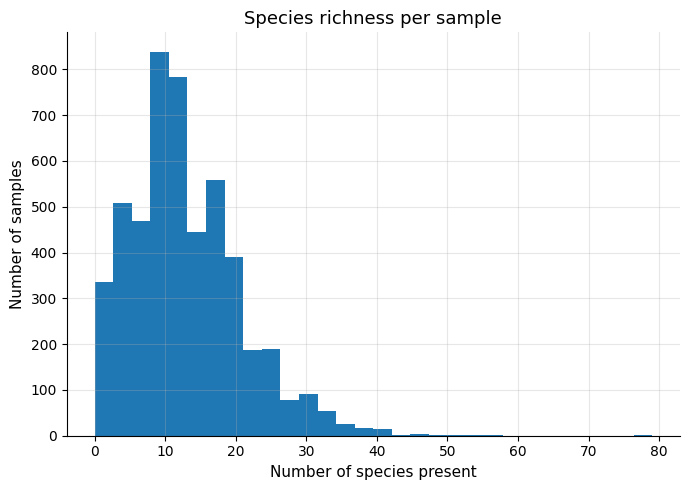

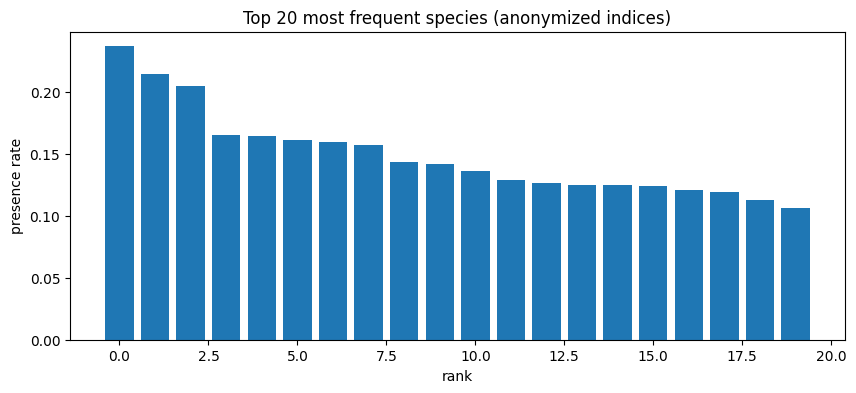

Top species indices: [ 15 128   6 135  68  89 315 321 304 310 338 341 189 296  33 207 183 191
 193 198]
Top species presence rates: [0.2368 0.2148 0.2046 0.1652 0.1646 0.161  0.1596 0.1574 0.1432 0.1416
 0.1362 0.1286 0.1264 0.1252 0.125  0.1242 0.121  0.1194 0.113  0.106 ]
Sample 0 has 6 species present.
Present species indices: [119 136 200 284 339 340] 


In [6]:

# species richness per sample

richness = Y.sum(axis=1)

plt.figure(figsize=(7,5))
plt.hist(richness, bins=30)
plt.title("Species richness per sample", fontsize=13)
plt.xlabel("Number of species present", fontsize=11)
plt.ylabel("Number of samples", fontsize=11)

plt.grid(True, alpha=0.3)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


# most common species across dataset
freq = Y.mean(axis=0)
top = np.argsort(-freq)[:20]

plt.figure(figsize=(10,4))
plt.bar(range(len(top)), freq[top])
plt.title("Top 20 most frequent species (anonymized indices)")
plt.xlabel("rank")
plt.ylabel("presence rate")
plt.show()

print("Top species indices:", top)
print("Top species presence rates:", freq[top])

idx = 0
present = np.where(Y[idx] == 1)[0]
print(f"Sample {idx} has {len(present)} species present.")
print("Present species indices:", present[:50], "..." if len(present) > 50 else "")


# Visualize climate variables


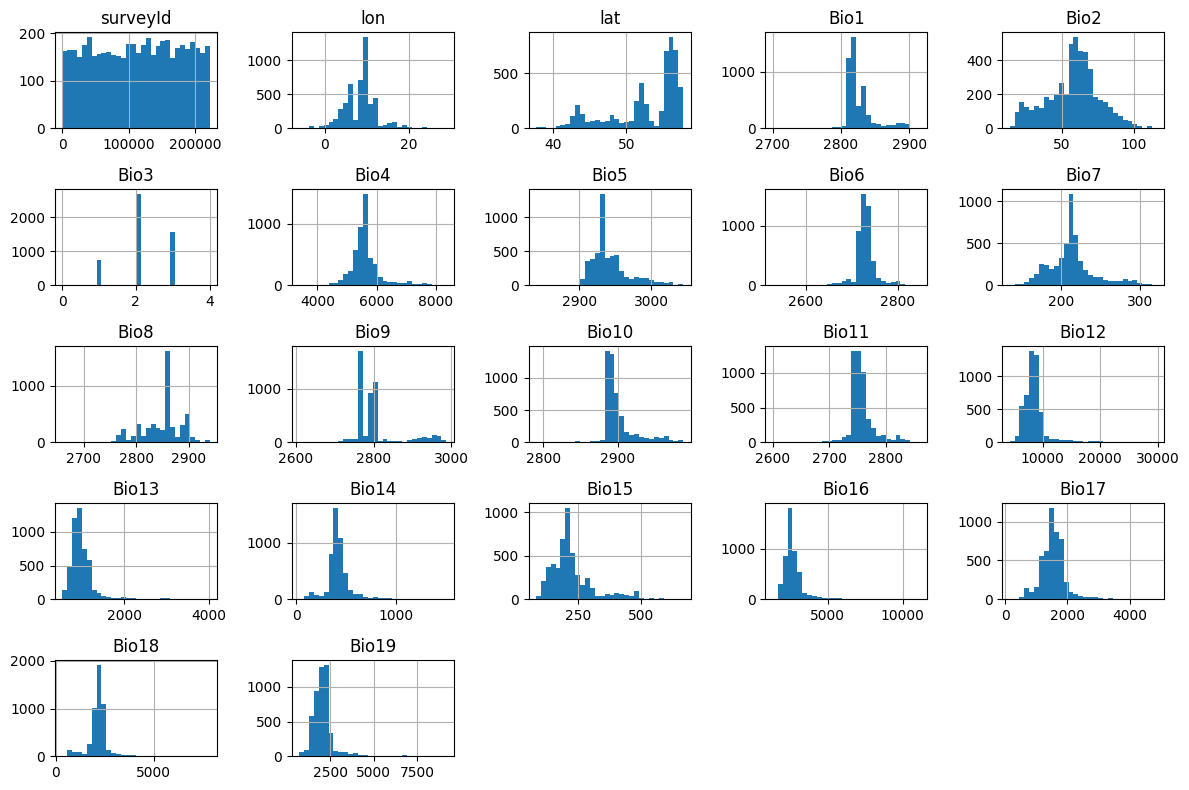

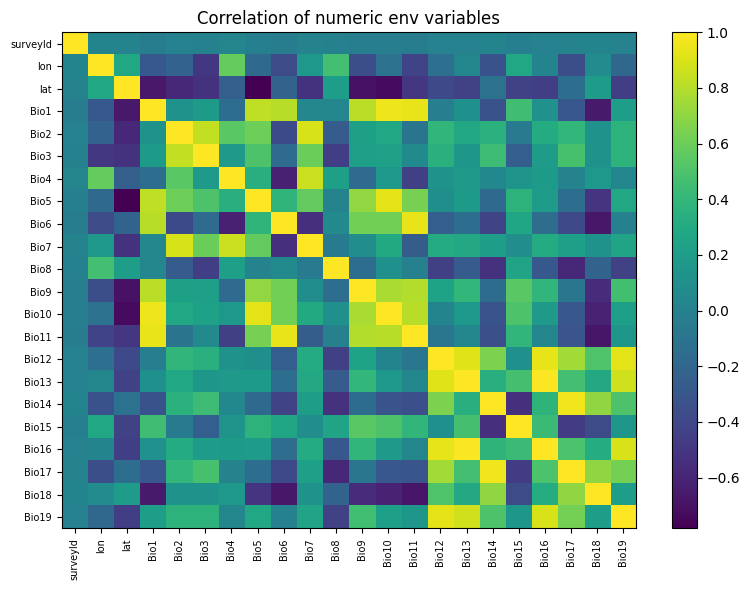

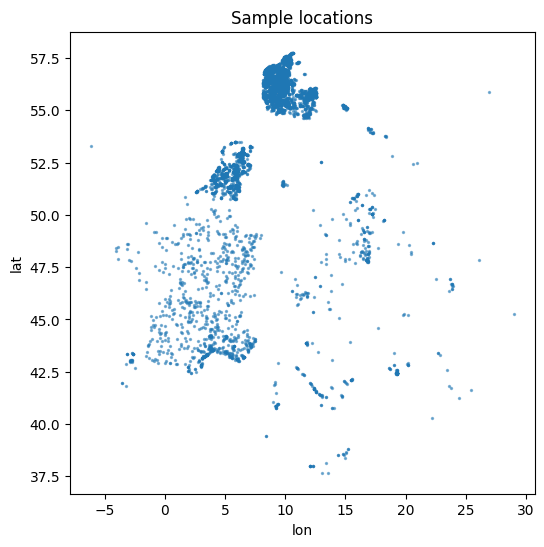

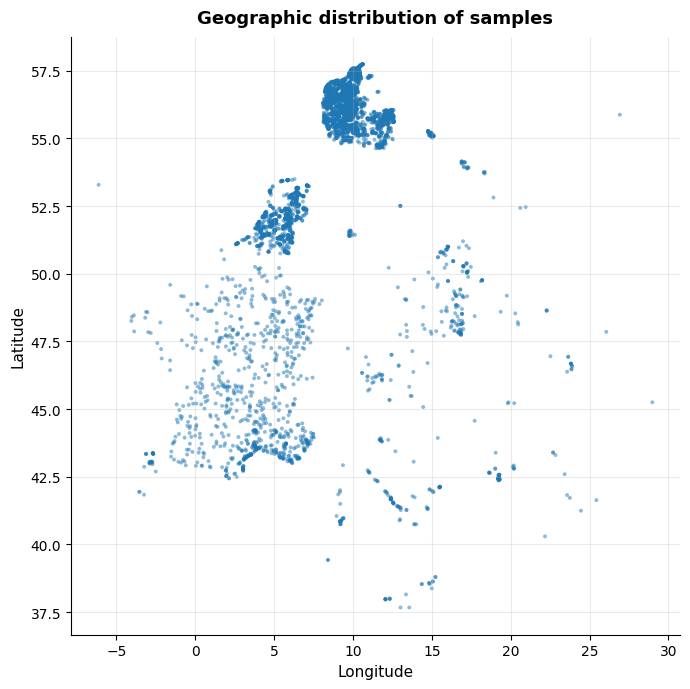

In [7]:

# quick distributions
env.select_dtypes(include="number").hist(figsize=(12,8), bins=30)
plt.tight_layout()
plt.show()

# correlation heatmap
num = env.select_dtypes(include="number")
corr = num.corr().to_numpy()

plt.figure(figsize=(8,6))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.title("Correlation of numeric env variables")
plt.xticks(range(num.shape[1]), num.columns, rotation=90, fontsize=7)
plt.yticks(range(num.shape[1]), num.columns, fontsize=7)
plt.tight_layout()
plt.show()

lat_cols = [c for c in env.columns if "lat" in c.lower()]
lon_cols = [c for c in env.columns if "lon" in c.lower()]

if lat_cols and lon_cols:
    lat, lon = lat_cols[0], lon_cols[0]
    plt.figure(figsize=(6,6))
    plt.scatter(env[lon], env[lat], s=2, alpha=0.5)
    plt.xlabel(lon); plt.ylabel(lat)
    plt.title("Sample locations")
    plt.show()


plt.figure(figsize=(7,7))

plt.scatter(
    env[lon], env[lat],
    s=8,
    alpha=0.5,
    edgecolors="none"
)

plt.xlabel("Longitude", fontsize=11)
plt.ylabel("Latitude", fontsize=11)
plt.title("Geographic distribution of samples", fontsize=13, weight="bold", pad=10)

# Light grid
plt.grid(True, alpha=0.25)

# Remove boxy look
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()



Visualize Landsat time series

   surveyId  landsat_red_2008_1  landsat_red_2008_2  landsat_red_2008_3  \
0       212                 7.0                 7.0                10.0   
1       222                18.0                15.0                23.0   
2       243                 6.0                 9.0                10.0   
3       324                23.0                23.0                10.0   
4       333                24.0                44.0                26.0   

   landsat_red_2008_4  landsat_red_2009_1  landsat_red_2009_2  \
0                 8.0                 6.0                10.0   
1                17.0                18.0                11.0   
2                10.0                 6.0                10.0   
3                15.0                29.0                41.0   
4                19.0                31.0                17.0   

   landsat_red_2009_3  landsat_red_2009_4  landsat_red_2010_1  ...  \
0                11.0                 8.0                 9.0  ...   
1                1

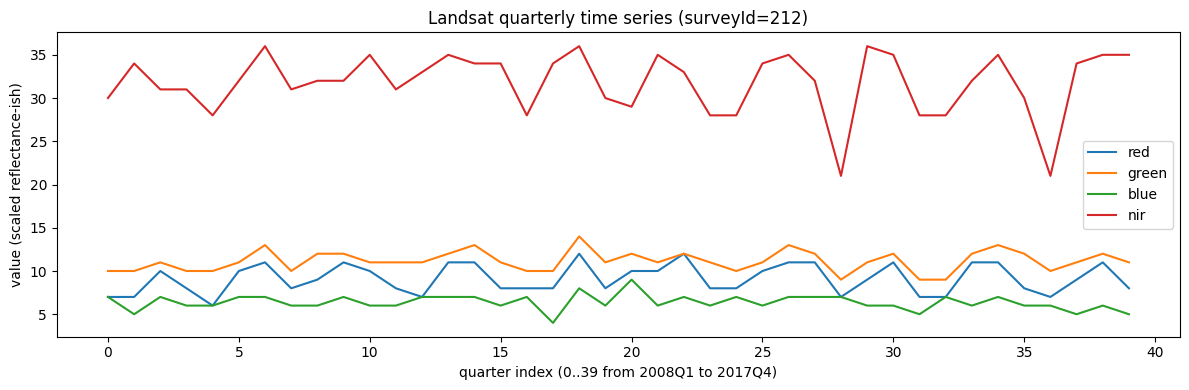

In [8]:
print(ts.head())
print(ts.columns)

i = 0
row = ts.iloc[i]

def cols_for(prefix):
    cols = [c for c in ts.columns if c.startswith(f"landsat_{prefix}_")]

    def key(c):
        year, q = map(int, re.findall(r"_(\d{4})_(\d)$", c)[0])
        return (year, q)

    cols.sort(key=key)
    return cols

red_cols   = cols_for("red")
green_cols = cols_for("green")
blue_cols  = cols_for("blue")
nir_cols   = cols_for("nir")

series = {
    "red":   row[red_cols].to_numpy(dtype=float),
    "green": row[green_cols].to_numpy(dtype=float),
    "blue":  row[blue_cols].to_numpy(dtype=float),
    "nir":   row[nir_cols].to_numpy(dtype=float),
}

t = np.arange(len(red_cols))
plt.figure(figsize=(12,4))
for name, v in series.items():
    plt.plot(t, v, label=name)

plt.title(f"Landsat quarterly time series (surveyId={int(row['surveyId'])})")
plt.xlabel("quarter index (0..39 from 2008Q1 to 2017Q4)")
plt.ylabel("value (scaled reflectance-ish)")
plt.legend()
plt.tight_layout()
plt.show()



In [9]:
i = 123
print("Label vector length:", Y[i].shape)
print("Image shape:", X_img[i].shape)
print("Env row:", env.iloc[i].to_dict())

Label vector length: (342,)
Image shape: (3, 128, 128)
Env row: {'surveyId': 5316.0, 'lon': 3.038266, 'lat': 42.70752, 'Bio1': 2890.0, 'Bio2': 75.0, 'Bio3': 3.0, 'Bio4': 5782.0, 'Bio5': 3019.0, 'Bio6': 2779.0, 'Bio7': 240.0, 'Bio8': 2858.0, 'Bio9': 2967.0, 'Bio10': 2967.0, 'Bio11': 2819.0, 'Bio12': 6482.0, 'Bio13': 915.0, 'Bio14': 169.0, 'Bio15': 370.0, 'Bio16': 2265.0, 'Bio17': 790.0, 'Bio18': 790.0, 'Bio19': 1962.0}


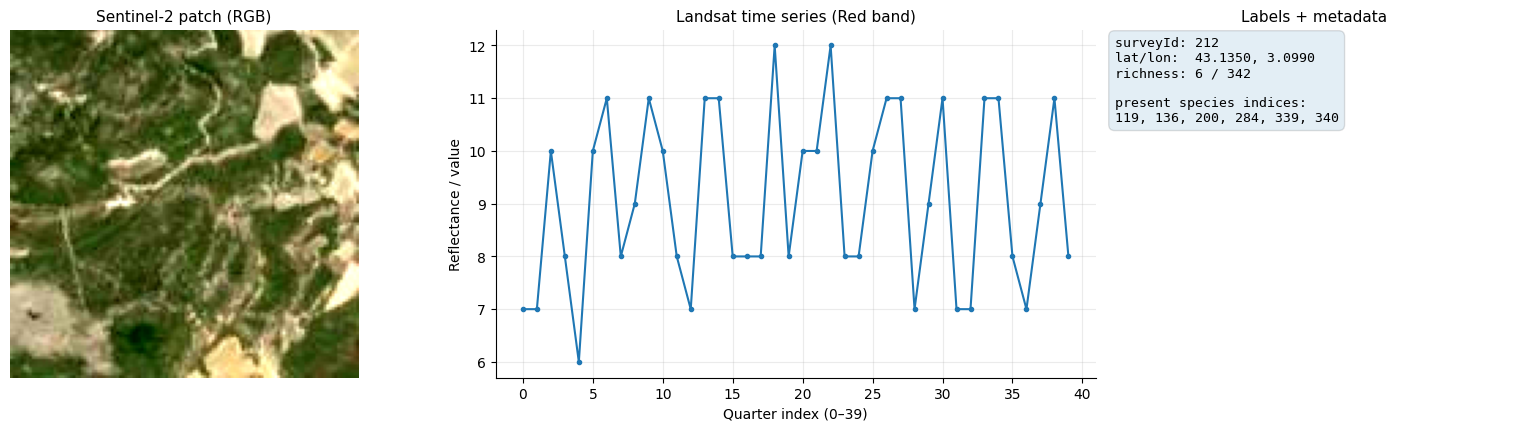

In [10]:
red_cols = cols_for("red")

# Build surveyId + row index maps
env_ids = env["surveyId"].astype(int).to_numpy()
ts_ids  = ts["surveyId"].astype(int).to_numpy()
env_map = {sid: idx for idx, sid in enumerate(env_ids)}
ts_map  = {sid: idx for idx, sid in enumerate(ts_ids)}

i = 0
survey_id = int(env_ids[i])

env_i = env_map.get(survey_id, None)
ts_i  = ts_map.get(survey_id, None)
if env_i is None or ts_i is None:
    raise ValueError(f"surveyId {survey_id} not found in env or ts.")

img = chw_to_hwc(X_img[i])

img_disp = img.astype(float)
lo, hi = np.percentile(img_disp, (2, 98))
img_disp = np.clip((img_disp - lo) / (hi - lo + 1e-8), 0, 1)

present = np.where(Y[i] == 1)[0]
richness = int(present.size)

K = 25
present_str = ", ".join(map(str, present[:K]))
if richness > K:
    present_str += ", ..."

red = ts.iloc[ts_i][red_cols].to_numpy(dtype=float)
t = np.arange(len(red))

lat = float(env.iloc[env_i]["lat"])
lon = float(env.iloc[env_i]["lon"])

fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(16, 4.2), constrained_layout=True,
    gridspec_kw={"width_ratios": [1.1, 1.3, 0.9]}
)

# --- Image ---
ax1.imshow(img_disp)
ax1.set_title("Sentinel-2 patch (RGB)", fontsize=11)
ax1.axis("off")

# --- Time series ---
ax2.plot(t, red, marker="o", markersize=3, linewidth=1.5)
ax2.set_title("Landsat time series (Red band)", fontsize=11)
ax2.set_xlabel("Quarter index (0–39)")
ax2.set_ylabel("Reflectance / value")
ax2.grid(True, alpha=0.25)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# --- Metadata card ---
ax3.axis("off")
ax3.set_title("Labels + metadata", fontsize=11)

meta_txt = (
    f"surveyId: {survey_id}\n"
    f"lat/lon:  {lat:.4f}, {lon:.4f}\n"
    f"richness: {richness} / 342\n\n"
    f"present species indices:\n{present_str}"
)

ax3.text(
    0.02, 0.98, meta_txt, va="top", ha="left",
    fontsize=9.5, family="monospace",
    bbox=dict(boxstyle="round,pad=0.45", alpha=0.12)
)

plt.show()


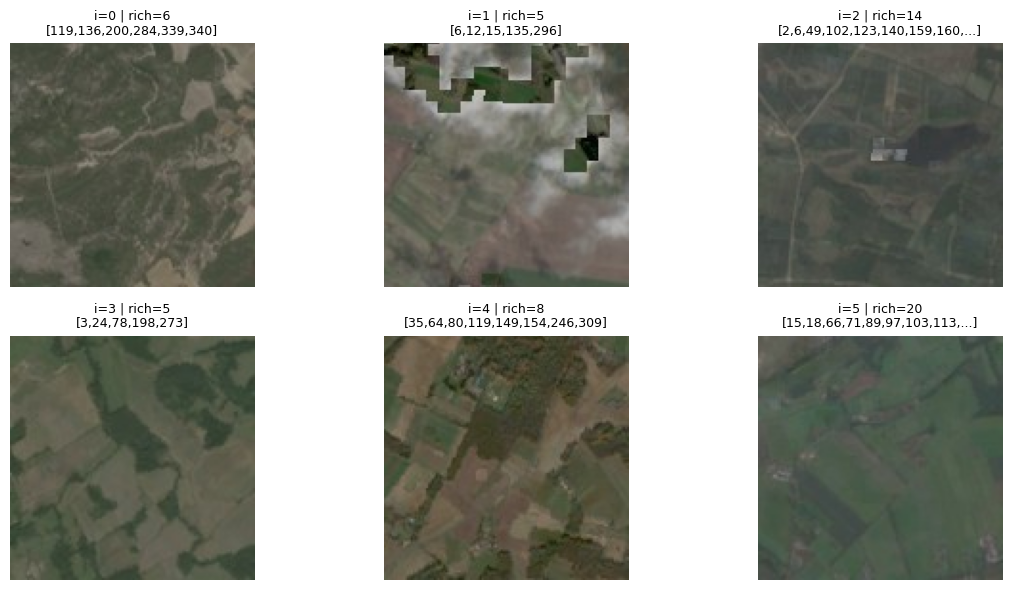

In [11]:

def show_samples(idxs, K=10):
    plt.figure(figsize=(12, 6))
    for j, i in enumerate(idxs, 1):
        img = np.transpose(X_img[i], (1,2,0)).astype(np.float32) / 255.0
        present = np.where(Y[i] == 1)[0]
        richness = int(present.size)
        present_str = ",".join(map(str, present[:K]))
        if richness > K:
            present_str += ",..."

        ax = plt.subplot(2, 3, j)
        ax.imshow(img)
        ax.set_title(f"i={i} | rich={richness}\n[{present_str}]",
                     fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_samples([0,1,2,3,4,5], K=8)


CLass Imbalance Analysis


presence rate min/median/max: 0.008 0.0248 0.2368
rare species (<1%): 40  / 342
ultra-rare (<0.1%): 0  / 342


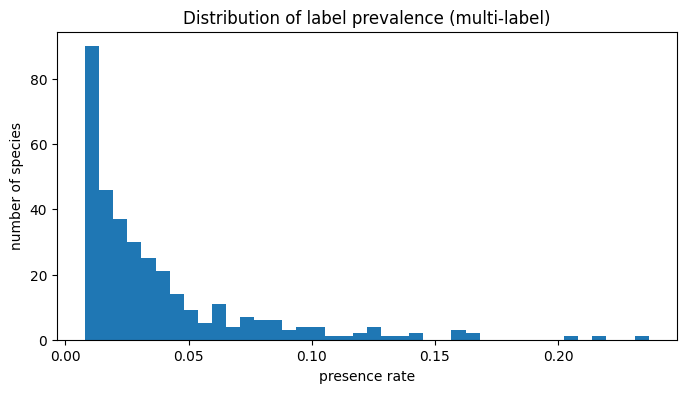

10 rarest species indices: [ 31  84 230  36 136  13 133  92 158 211] rates: [0.008  0.0082 0.0082 0.0082 0.0084 0.0084 0.0084 0.0084 0.0084 0.0084]
10 most common species indices: [ 15 128   6 135  68  89 315 321 304 310] rates: [0.2368 0.2148 0.2046 0.1652 0.1646 0.161  0.1596 0.1574 0.1432 0.1416]


In [12]:
freq = Y.mean(axis=0)
pos_count = Y.sum(axis=0)
neg_count = Y.shape[0] - pos_count

print("presence rate min/median/max:", float(freq.min()), float(np.median(freq)), float(freq.max()))
print("rare species (<1%):", int((freq < 0.01).sum()), " / 342")
print("ultra-rare (<0.1%):", int((freq < 0.001).sum()), " / 342")

plt.figure(figsize=(8,4))
plt.hist(freq, bins=40)
plt.title("Distribution of label prevalence (multi-label)")
plt.xlabel("presence rate")
plt.ylabel("number of species")
plt.show()

bottom = np.argsort(freq)[:10]
top = np.argsort(-freq)[:10]
print("10 rarest species indices:", bottom, "rates:", freq[bottom])
print("10 most common species indices:", top, "rates:", freq[top])

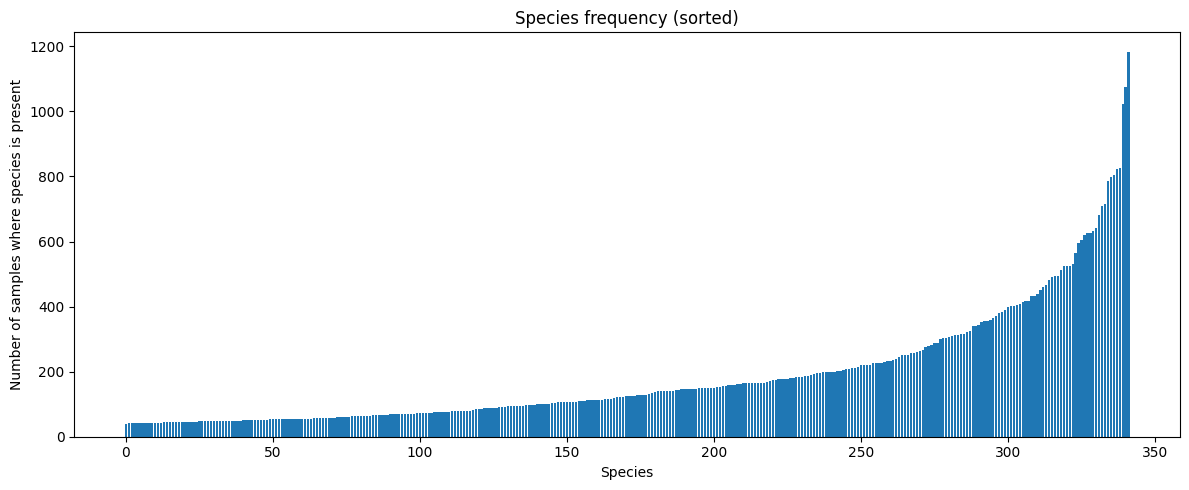

In [16]:
order = np.argsort(pos_count)
plt.figure(figsize=(12,5))
plt.bar(np.arange(len(pos_count)), pos_count[order])

plt.xlabel("Species")
plt.ylabel("Number of samples where species is present")
plt.title("Species frequency (sorted)")

plt.tight_layout()
plt.show()


Functions to make things easier

In [14]:
def train_model(model, optimizer, loss_fn, X_tr, Y_tr, n_epochs, print_every=5, label="Training"):
    logits = None

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()

        logits = model(X_tr)
        loss = loss_fn(logits, Y_tr)

        loss.backward()
        optimizer.step()

    return logits


@torch.no_grad()
def compute_per_class_recall(model, X, Y, threshold=0.5):

    model.eval()
    logits = model(X)
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).int()

    tp = ((Y == 1) & (preds == 1)).sum(dim=0)
    fn = ((Y == 1) & (preds == 0)).sum(dim=0)

    recall = tp / (tp + fn + 1e-6)
    return recall

def plot_recall_vs_frequency(pos_count, recall_unw, recall_w):
    plt.figure(figsize=(8,4))
    plt.scatter(pos_count, recall_unw, s=10, alpha=0.6, label="unweighted")
    plt.scatter(pos_count, recall_w,   s=10, alpha=0.6, label="weighted")
    plt.xlabel("pos_count in training")
    plt.ylabel("recall per class (test set)")
    plt.title("Test recall vs class frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

Loss Re-Weighting

In [14]:

K = 342
Y_t = torch.tensor(Y, dtype=torch.float32)            

pos_count = torch.tensor(pos_count, dtype=torch.float32)
neg_count = torch.tensor(N - pos_count, dtype=torch.float32)

# avoid dividing by zero
eps = 1.0
pos_weight = neg_count / (pos_count + eps)

# clip weights
pos_weight = torch.clamp(pos_weight, min=1.0, max=50.0)

print("pos_weight stats:", float(pos_weight.min()), float(pos_weight.median()), float(pos_weight.max()))

# Use in BCE
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


pos_weight stats: 3.2202532291412354 39.007999420166016 50.0


/tmp/ipykernel_96302/3428824093.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_count = torch.tensor(N - pos_count, dtype=torch.float32)


Comparing unweighted to reweighted

In [15]:
model_unw = SimpleMLP(X_tr.shape[1], K)
model_w   = SimpleMLP(X_tr.shape[1], K)
n_epochs = 25

# same initialization for fair comparison
model_w.load_state_dict(model_unw.state_dict())

optimizer_unw = torch.optim.Adam(model_unw.parameters(), lr=1e-3)
optimizer_w   = torch.optim.Adam(model_w.parameters(), lr=1e-3)

criterion_unw = nn.BCEWithLogitsLoss()

# train with unweighted weights
logits_unw = train_model(
    model=model_unw,
    optimizer=optimizer_unw,
    loss_fn=lambda z, y: criterion_unw(z, y),
    X_tr=X_tr,
    Y_tr=Y_t,
    n_epochs=n_epochs,
    label="Unweighted BCE"
)


# train with reweighted weights
logits_w = train_model(
    model=model_w,
    optimizer=optimizer_w,
    loss_fn=lambda z, y: criterion(z, y),
    X_tr=X_tr,
    Y_tr=Y_t,
    n_epochs=n_epochs,
    label="Reweighted BCE"
)



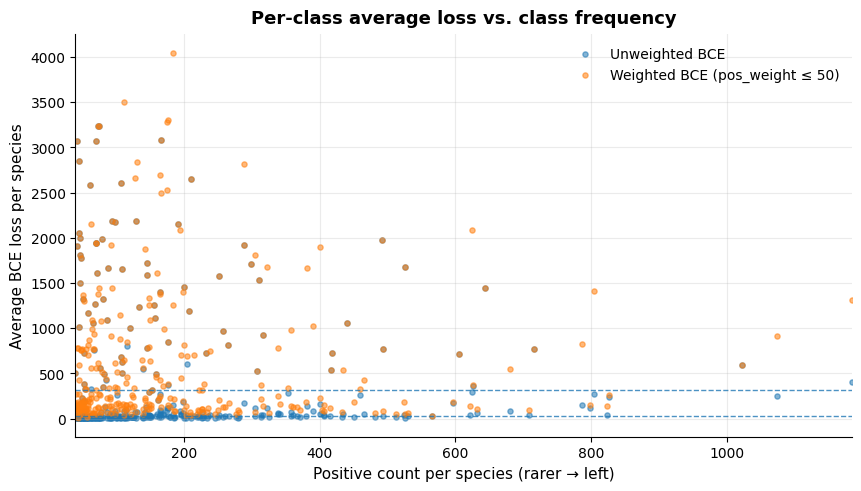

In [16]:

logits0 = logits_unw.detach()
logits1 = logits_w.detach()

pos_weight_cap = 50.0
pos_weight_t = pos_weight

# Per-class losses
loss_unw_elem = F.binary_cross_entropy_with_logits(logits0, Y_t, reduction="none")
loss_unw_per_class = loss_unw_elem.mean(dim=0).cpu().numpy()

loss_w_elem = F.binary_cross_entropy_with_logits(
    logits1, Y_t, pos_weight=pos_weight_t, reduction="none"
)
loss_w_per_class = loss_w_elem.mean(dim=0).cpu().numpy()

# Positive counts per class
pos_count = Y_t.sum(dim=0).cpu().numpy()

fig, ax = plt.subplots(figsize=(8.5, 4.8), constrained_layout=True)

ax.scatter(pos_count, loss_unw_per_class, s=14, alpha=0.55, label="Unweighted BCE")
ax.scatter(pos_count, loss_w_per_class,  s=14, alpha=0.55, label=f"Weighted BCE (pos_weight ≤ {pos_weight_cap:g})")

ax.axhline(np.median(loss_unw_per_class), linestyle="--", linewidth=1, alpha=0.8)
ax.axhline(np.median(loss_w_per_class),   linestyle="--", linewidth=1, alpha=0.8)

ax.set_title("Per-class average loss vs. class frequency", fontsize=13, weight="bold", pad=8)
ax.set_xlabel("Positive count per species (rarer → left)", fontsize=11)
ax.set_ylabel("Average BCE loss per species", fontsize=11)

ax.grid(True, which="both", axis="both", alpha=0.25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(frameon=False, fontsize=10)
xmin = max(1, np.min(pos_count[pos_count > 0]))
xmax = np.max(pos_count)
ax.set_xlim(xmin, xmax)

plt.show()



Total recall (unweighted): 0.3012438416481018
Total recall (weighted):   0.4832920730113983
Improvement: 0.1820482313632965

Rare species recall (unweighted): 0.3194848299026489
Rare species recall (weighted):   0.4843887984752655
Improvement: 0.16490396857261658

Common species recall (unweighted): 0.30916541814804077
Common species recall (weighted):   0.49571287631988525
Improvement: 0.18654745817184448


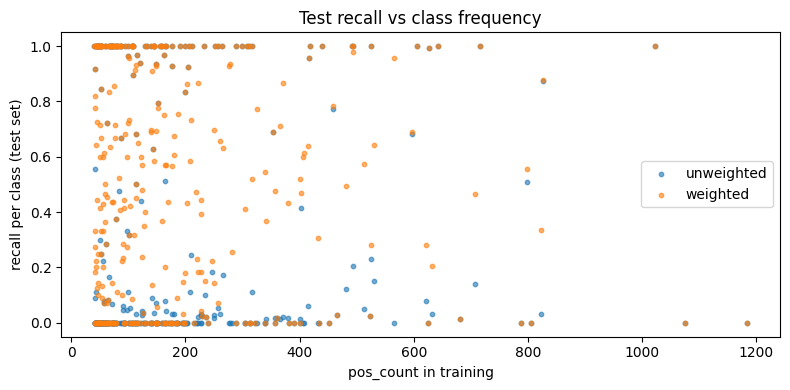

In [17]:

recall_unw = compute_per_class_recall(model_unw, X_te, Y_te)
recall_w   = compute_per_class_recall(model_w,   X_te, Y_te)

print("Total recall (unweighted):", recall_unw.mean().item())
print("Total recall (weighted):  ", recall_w.mean().item())
print("Improvement:", (recall_w.mean() - recall_unw.mean()).item())

pos_count_tr = Y_tr.sum(dim=0)

rare_idx   = torch.argsort(pos_count_tr)[:50]
common_idx = torch.argsort(pos_count_tr)[-50:]

print("\nRare species recall (unweighted):", recall_unw[rare_idx].mean().item())
print("Rare species recall (weighted):  ", recall_w[rare_idx].mean().item())
print("Improvement:", (recall_w[rare_idx].mean() - recall_unw[rare_idx].mean()).item())

print("\nCommon species recall (unweighted):", recall_unw[common_idx].mean().item())
print("Common species recall (weighted):  ", recall_w[common_idx].mean().item())
print("Improvement:", (recall_w[common_idx].mean() - recall_unw[common_idx].mean()).item())

plot_recall_vs_frequency(pos_count_tr, recall_unw, recall_w)



Focal Loss

In [18]:
def focal_loss_with_logits(logits, targets, gamma=2.0, alpha=None, pos_weight=None, reduction="mean"):

    targets = targets.type_as(logits)

    # Stable BCE per element
    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none") 

    # p_t = p if y=1 else (1-p)
    p = torch.sigmoid(logits)
    p_t = p * targets + (1 - p) * (1 - targets)

    focal_factor = (1 - p_t).pow(gamma)
    loss = focal_factor * bce 

    # balancing
    if alpha is not None:
        if not torch.is_tensor(alpha):
            alpha_t = torch.tensor(alpha, device=logits.device, dtype=logits.dtype)
        else:
            alpha_t = alpha.to(device=logits.device, dtype=logits.dtype)
        alpha_factor = alpha_t * targets + (1 - alpha_t) * (1 - targets)
        loss = alpha_factor * loss

    # scales the positive terms
    if pos_weight is not None:
        pw = pos_weight.to(device=logits.device, dtype=logits.dtype).view(1, -1) 
        loss = loss * (1 + (pw - 1) * targets)

    if reduction == "mean":
        return loss.mean()
    if reduction == "sum":
        return loss.sum()
    return loss 



Total recall (focal unweighted): 0.3051810562610626
Total recall (focal weighted):   0.4573012590408325
Improvement: 0.1521202027797699

Rare species recall (focal unweighted): 0.2875252068042755
Rare species recall (focal weighted):   0.3600848913192749
Improvement: 0.07255968451499939

Common species recall (focal unweighted): 0.3318161070346832
Common species recall (focal weighted):   0.5187380909919739
Improvement: 0.18692198395729065


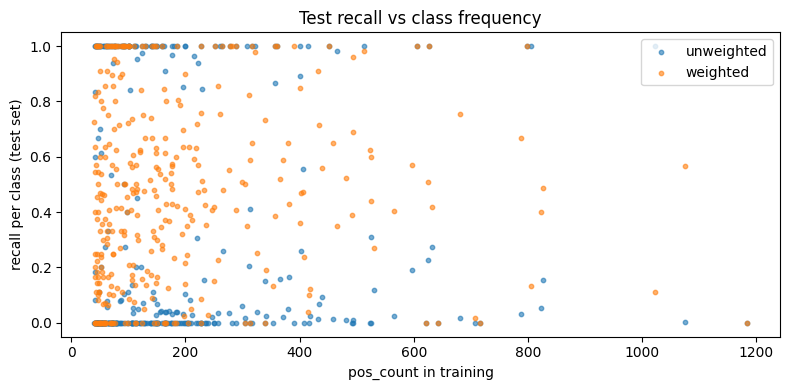

In [19]:

model_focal_unw = SimpleMLP(X_tr.shape[1], K)
optimizer_focal_unw = torch.optim.Adam(model_focal_unw.parameters(), lr=1e-3)

gamma = 2.0

train_model(
    model=model_focal_unw,
    optimizer=optimizer_focal_unw,
    loss_fn=lambda z, y: focal_loss_with_logits(z, y, gamma=gamma),
    X_tr=X_tr,
    Y_tr=Y_tr,
    n_epochs=n_epochs,
    label="Unweighted focal"
)

model_focal_w = SimpleMLP(X_tr.shape[1], K)
model_focal_w.load_state_dict(model_focal_unw.state_dict())

optimizer_focal_w = torch.optim.Adam(model_focal_w.parameters(), lr=1e-3)

train_model(
    model=model_focal_w,
    optimizer=optimizer_focal_w,
    loss_fn=lambda z, y: focal_loss_with_logits(z, y, gamma=gamma, pos_weight=pos_weight),
    X_tr=X_tr,
    Y_tr=Y_tr,
    n_epochs=n_epochs,
    label="Reweighted focal"
)

recall_focal_unw = compute_per_class_recall(
    model_focal_unw, X_te, Y_te
)
recall_focal_w = compute_per_class_recall(
    model_focal_w, X_te, Y_te
)

print("\nTotal recall (focal unweighted):", recall_focal_unw.mean().item())
print("Total recall (focal weighted):  ", recall_focal_w.mean().item())
print("Improvement:", (recall_focal_w.mean() - recall_focal_unw.mean()).item())

rare_idx   = torch.argsort(pos_count_tr)[:50]
common_idx = torch.argsort(pos_count_tr)[-50:]

print("\nRare species recall (focal unweighted):", recall_focal_unw[rare_idx].mean().item())
print("Rare species recall (focal weighted):  ", recall_focal_w[rare_idx].mean().item())
print("Improvement:", (recall_focal_w[rare_idx].mean() - recall_focal_unw[rare_idx].mean()).item())


print("\nCommon species recall (focal unweighted):", recall_focal_unw[common_idx].mean().item())
print("Common species recall (focal weighted):  ", recall_focal_w[common_idx].mean().item())
print("Improvement:", (recall_focal_w[common_idx].mean() - recall_focal_unw[common_idx].mean()).item())

plot_recall_vs_frequency(pos_count_tr, recall_focal_unw, recall_focal_w)



Asymmetrical Loss

In [20]:

def asym_loss_with_logits(
    logits: torch.Tensor,
    targets: torch.Tensor,
    gamma_pos: float = 0.0,
    gamma_neg: float = 4.0,
    clip: float = 0.05,
    eps: float = 1e-8,
    pos_weight: torch.Tensor | None = None,
    reduction: str = "mean",
):

    targets = targets.float()
    prob = torch.sigmoid(logits)
    prob_pos = prob
    prob_neg = 1.0 - prob

    # make easy negatives contribute less
    if clip is not None and clip > 0:
        prob_neg = torch.clamp(prob_neg + clip, max=1.0)

    # basic BCE terms
    log_pos = torch.log(torch.clamp(prob_pos, min=eps))
    log_neg = torch.log(torch.clamp(prob_neg, min=eps))

    loss_pos = targets * log_pos
    loss_neg = (1.0 - targets) * log_neg

    # asymmetric focusing
    if gamma_pos > 0 or gamma_neg > 0:
        pt_pos = prob_pos * targets
        pt_neg = prob_neg * (1.0 - targets)

        w_pos = torch.pow(1.0 - pt_pos, gamma_pos) * targets
        w_neg = torch.pow(1.0 - pt_neg, gamma_neg) * (1.0 - targets)

        loss_pos = loss_pos * w_pos
        loss_neg = loss_neg * w_neg

    # positive reweighting for rare classes
    if pos_weight is not None:
        loss_pos = loss_pos * pos_weight

    loss = -(loss_pos + loss_neg) 

    if reduction == "mean":
        return loss.mean()
    if reduction == "sum":
        return loss.sum()
    return loss

In [21]:
model_asl = SimpleMLP(X_tr.shape[1], K)
optimizer_asl = torch.optim.Adam(model_asl.parameters(), lr=1e-3)


train_model(
    model=model_asl,
    optimizer=optimizer_asl,
    loss_fn=lambda z, y: asym_loss_with_logits(z, y, gamma_pos=0.0, gamma_neg=4.0),
    X_tr=X_tr,
    Y_tr=Y_t,
    n_epochs=n_epochs,
    label="Reweighted BCE"
)

recall_asl = compute_per_class_recall(model_asl, X_te, Y_te)


Try to find best hyperparam

Top 10 settings:
 gamma_neg  clip  rare_recall_mean  rare_recall_std
       2.0  0.05          0.335427         0.066133
       4.0  0.05          0.335261         0.071483
       1.0  0.05          0.333913         0.066789
       6.0  0.05          0.333631         0.068832
       2.0  0.00          0.324701         0.071242
       4.0  0.00          0.324416         0.070916
       6.0  0.00          0.323507         0.071334
       1.0  0.00          0.322646         0.071646

BEST setting:
{'gamma_neg': 2.0, 'clip': 0.05, 'rare_recall_mean': 0.3354272902011871, 'rare_recall_std': 0.06613310383583582}

Rare recall mean (rows=gamma_neg, cols=clip):
clip           0.00      0.05
gamma_neg                    
1.0        0.322646  0.333913
2.0        0.324701  0.335427
4.0        0.324416  0.335261
6.0        0.323507  0.333631


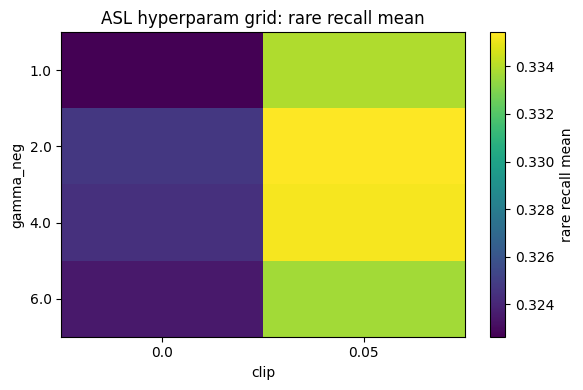

In [22]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
gamma_negs = [1.0, 2.0, 4.0, 6.0]
clips = [0.0, 0.05]

results = []

for gamma_neg in gamma_negs:
    for clip in clips:
        rare_recalls = []

        for seed in seeds:
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)

            model = SimpleMLP(X_tr.shape[1], K)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

            train_model(
                model,
                optimizer,
                loss_fn=lambda z, y: asym_loss_with_logits(
                    z, y,
                    gamma_pos=0.0,
                    gamma_neg=gamma_neg,
                    clip=clip
                ),
                X_tr=X_tr,
                Y_tr=Y_tr,
                n_epochs=n_epochs
            )

            recall = compute_per_class_recall(model, X_te, Y_te)
            rare_recalls.append(recall[rare_idx].mean().item())

        results.append({
            "gamma_neg": gamma_neg,
            "clip": clip,
            "rare_recall_mean": np.mean(rare_recalls),
            "rare_recall_std": np.std(rare_recalls),
        })
        
df = pd.DataFrame(results)

df_sorted = df.sort_values(
    by=["rare_recall_mean", "rare_recall_std"],
    ascending=[False, True]
)

print("Top 10 settings:")
print(df_sorted.head(10).to_string(index=False))

best = df_sorted.iloc[0]
print("\nBEST setting:")
print(best.to_dict())

pivot = df.pivot(index="gamma_neg", columns="clip", values="rare_recall_mean")
print("\nRare recall mean (rows=gamma_neg, cols=clip):")
print(pivot)

plt.figure(figsize=(6,4))
plt.imshow(pivot.values, aspect="auto")
plt.colorbar(label="rare recall mean")
plt.xticks(range(len(pivot.columns)), [str(c) for c in pivot.columns])
plt.yticks(range(len(pivot.index)), [str(g) for g in pivot.index])
plt.xlabel("clip")
plt.ylabel("gamma_neg")
plt.title("ASL hyperparam grid: rare recall mean")
plt.tight_layout()
plt.show()




COMPARE THE 3 MODELS

In [23]:
def plot_recall_comparison(
    pos_count,
    recall_dict,
    n_bins=20,
    title=""
    ):
    pos = np.asarray(pos_count)

    # sort by frequency
    order = np.argsort(pos)
    pos = pos[order]

    # prepare bins
    bins = np.array_split(np.arange(len(pos)), n_bins)

    def bin_mean(x, y):
        bx = [x[b].mean() for b in bins]
        by = [y[b].mean() for b in bins]
        return np.array(bx), np.array(by)

    plt.figure(figsize=(9,4))

    for label, recall in recall_dict.items():
        r = np.asarray(recall)[order]
        x, y = bin_mean(pos, r)
        plt.plot(x, y, "-o", linewidth=2, label=label)

    plt.xlabel("pos_count in training")
    plt.ylabel("mean recall (test set)")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


The graph isnt the most useful since it always changes so let's average out over 10 seeds

In [24]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

macro_rw, macro_focal = [], []
rare_rw, rare_focal = [], []
macro_asl, rare_asl = [], []

n_epochs = 25

for s in seeds:
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)

    model_base = SimpleMLP(X_tr.shape[1], K)
    model_rw   = SimpleMLP(X_tr.shape[1], K)
    model_foc  = SimpleMLP(X_tr.shape[1], K)
    model_asl  = SimpleMLP(X_tr.shape[1], K)

    model_rw.load_state_dict(model_base.state_dict())
    model_foc.load_state_dict(model_base.state_dict())
    model_asl.load_state_dict(model_base.state_dict())

    opt_rw  = torch.optim.Adam(model_rw.parameters(), lr=1e-3)
    opt_foc = torch.optim.Adam(model_foc.parameters(), lr=1e-3)
    opt_asym = torch.optim.Adam(model_asl.parameters(), lr=1e-3)

    # train loss reweighting
    model_rw.train()
    for _ in range(n_epochs):
        opt_rw.zero_grad()
        logits = model_rw(X_tr)
        loss = criterion(logits, Y_tr)
        loss.backward()
        opt_rw.step()

    # train focal loss
    model_foc.train()
    for _ in range(n_epochs):
        opt_foc.zero_grad()
        logits = model_foc(X_tr)
        loss = focal_loss_with_logits(logits, Y_tr) 
        loss.backward()
        opt_foc.step()
        
    # train asym loss
    model_asl.train()
    for _ in range(n_epochs):
        opt_asym.zero_grad()
        logits = model_asl(X_tr)
        loss = asym_loss_with_logits(logits, Y_tr, gamma_pos=0.0, gamma_neg=6.0)
        loss.backward()
        opt_asym.step()

    recall_rw = compute_per_class_recall(model_rw, X_te, Y_te)
    recall_f  = compute_per_class_recall(model_foc, X_te, Y_te)
    recall_asl = compute_per_class_recall(model_asl, X_te, Y_te)

    macro_rw.append(recall_rw.mean().item())
    macro_focal.append(recall_f.mean().item())
    macro_asl.append(recall_asl.mean().item())

    rare_rw.append(recall_rw[rare_idx].mean().item())
    rare_focal.append(recall_f[rare_idx].mean().item())
    rare_asl.append(recall_asl[rare_idx].mean().item())

print("\nReweighting: ")
print("   Total recall:     ", np.mean(macro_rw), "+/-", np.std(macro_rw))
print("   Rare recall:      ", np.mean(rare_rw), "+/-", np.std(rare_rw))

print("\nFocal Loss: ")
print("   Total recall:      ", np.mean(macro_focal), "+/-", np.std(macro_focal))
print("   Rare recall :       ", np.mean(rare_focal), "+/-", np.std(rare_focal))

print("\nAsymmetric Loss: ")
print("   Total recall:      ", np.mean(macro_asl), "+/-", np.std(macro_asl))
print("   Rare recall :       ", np.mean(rare_asl), "+/-", np.std(rare_asl))


Reweighting: 
   Total recall:      0.46788502633571627 +/- 0.020766674959360434
   Rare recall:       0.3861638009548187 +/- 0.10042116607639381

Focal Loss: 
   Total recall:       0.2874113455414772 +/- 0.02440135942615617
   Rare recall :        0.25078060775995253 +/- 0.08292078136986177

Asymmetric Loss: 
   Total recall:       0.3970811814069748 +/- 0.01633140974341238
   Rare recall :        0.3336311772465706 +/- 0.06883166322011879


Reweighting delivers the strongest and most stable improvement in both total and rare-species recall, indicating that class frequency imbalance is the dominant issue in the dataset. 
Focal loss provides low recall gains but with higher variance, suggesting that it suppresses easy negatives but does not address extreme positive rarity.
Asymmetric loss gives average performance. It improves recall relative to focal loss but remaining less effective than reweighting because negative dominance is not the main bottleneck.

Data Loader and trying to resample

In [25]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

def make_multilabel_weighted_sampler(Y, eps=1e-6):

    # ensure tensor
    if not torch.is_tensor(Y):
        Y = torch.tensor(Y, dtype=torch.float32)
    else:
        Y = Y.float()

    N, K = Y.shape

    # class frequencies
    pos_freq = Y.mean(dim=0)
    inv_freq = 1.0 / (pos_freq + eps)

    sample_weights = torch.zeros(N)

    for i in range(N):
        pos_idx = (Y[i] == 1).nonzero(as_tuple=True)[0]
        if len(pos_idx) > 0:
            sample_weights[i] = inv_freq[pos_idx].mean()
        else:
            sample_weights[i] = 1.0

    # normalize
    sample_weights = sample_weights / sample_weights.mean()

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=N,
        replacement=True
    )

    return sampler

def make_loader(dataset, batch_size=64, shuffle=True, num_workers=0):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

class FullDataset(Dataset):
    def __init__(self, split="training", root="data",
                 use_img=True, use_env=True, use_ts=True):

        # load
        self.X_img = np.load(f"{root}/satellite_patches_{split}.npy")
        self.Y     = np.load(f"{root}/species_data_{split}.npy")
        self.env   = pd.read_csv(f"{root}/env_variables_{split}.csv")
        self.ts    = pd.read_csv(f"{root}/landsat_timeseries_{split}.csv")

        # align rows by surveyId
        self.env = self.env.sort_values("surveyId").reset_index(drop=True)
        self.ts  = self.ts.sort_values("surveyId").reset_index(drop=True)

        # everything except surveyId
        self.env_cols = [c for c in self.env.columns if c != "surveyId"]
        self.X_env = self.env[self.env_cols].to_numpy(np.float32)

        self.ts_cols = [c for c in self.ts.columns if c != "surveyId"]
        self.X_ts_flat = self.ts[self.ts_cols].to_numpy(np.float32)

        self.use_img = use_img
        self.use_env = use_env
        self.use_ts  = use_ts

    def __len__(self):
        return self.Y.shape[0]

    def __getitem__(self, i):
        out = {}

        if self.use_img:
            img = self.X_img[i].astype(np.float32) / 255.0
            out["img"] = torch.from_numpy(img)

        if self.use_env:
            out["env"] = torch.from_numpy(self.X_env[i])

        if self.use_ts:
            out["ts"] = torch.from_numpy(self.X_ts_flat[i])

        y = self.Y[i].astype(np.float32)
        out["y"] = torch.from_numpy(y)

        if "surveyId" in self.env.columns:
            out["surveyId"] = int(self.env.iloc[i]["surveyId"])

        return out


train_ds = FullDataset("training", root="../data", use_img=True, use_env=True, use_ts=True)
test_ds  = FullDataset("test",     root="../data", use_img=True, use_env=True, use_ts=True)

train_loader = make_loader(train_ds, batch_size=32, shuffle=True)
test_loader  = make_loader(test_ds, batch_size=32, shuffle=False)

sampler = make_multilabel_weighted_sampler(train_ds.Y)
train_loader_weighted = DataLoader(train_ds, batch_size=32, sampler=sampler, shuffle=False)


trying to combine all 3

In [26]:

def combined_losses(
    logits, targets,
    pos_weight=None,
    gamma_pos=0.0,
    gamma_neg=4.0,
    clip=0.05,
    reduction="mean",
    eps=1e-8
):

    y = targets.float()
    p = torch.sigmoid(logits)

    # ASL clipping of negative probs
    if clip is not None and clip > 0:
        p_clipped = torch.where(y < 0.5, torch.clamp(p + clip, max=1.0), p)
    else:
        p_clipped = p

    log_p = torch.log(p.clamp(min=eps))
    log_1mp = torch.log((1.0 - p_clipped).clamp(min=eps))

    # focal/asymmetric focusing factors
    w_pos = (1.0 - p).clamp(min=eps).pow(gamma_pos)
    w_neg = p_clipped.clamp(min=eps).pow(gamma_neg)

    # reweight positives by pos_weight
    if pos_weight is not None:
        if pos_weight.ndim == 1:
            pos_w = pos_weight.view(1, -1)
        else:
            pos_w = pos_weight
    else:
        pos_w = 1.0

    # combined loss
    loss_pos = - pos_w * y * w_pos * log_p
    loss_neg = - (1.0 - y) * w_neg * log_1mp
    loss = loss_pos + loss_neg

    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss


In [27]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

macro_rw, macro_focal, macro_asl, macro_combo = [], [], [], []
rare_rw, rare_focal, rare_asl, rare_combo = [], [], [], []

n_epochs = 25

for s in seeds:
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)

    model_base = SimpleMLP(X_tr.shape[1], K)
    model_rw   = SimpleMLP(X_tr.shape[1], K)
    model_foc  = SimpleMLP(X_tr.shape[1], K)
    model_asl  = SimpleMLP(X_tr.shape[1], K)
    model_combo = SimpleMLP(X_tr.shape[1], K)

    model_rw.load_state_dict(model_base.state_dict())
    model_foc.load_state_dict(model_base.state_dict())
    model_asl.load_state_dict(model_base.state_dict())
    model_combo.load_state_dict(model_base.state_dict())

    opt_rw   = torch.optim.Adam(model_rw.parameters(), lr=1e-3)
    opt_foc  = torch.optim.Adam(model_foc.parameters(), lr=1e-3)
    opt_asym = torch.optim.Adam(model_asl.parameters(), lr=1e-3)
    opt_combo = torch.optim.Adam(model_combo.parameters(), lr=1e-3)

    # ---- train loss reweighting ----
    model_rw.train()
    for _ in range(n_epochs):
        opt_rw.zero_grad()
        logits = model_rw(X_tr)
        loss = criterion(logits, Y_tr)
        loss.backward()
        opt_rw.step()

    # ---- train focal loss ----
    model_foc.train()
    for _ in range(n_epochs):
        opt_foc.zero_grad()
        logits = model_foc(X_tr)
        loss = focal_loss_with_logits(logits, Y_tr)
        loss.backward()
        opt_foc.step()
        
    # ---- train asym loss ----
    model_asl.train()
    for _ in range(n_epochs):
        opt_asym.zero_grad()
        logits = model_asl(X_tr)
        loss = asym_loss_with_logits(logits, Y_tr, gamma_pos=0.0, gamma_neg=6.0)
        loss.backward()
        opt_asym.step()

    # ---- train combined loss ----
    model_combo.train()
    for _ in range(n_epochs):
        opt_combo.zero_grad()
        logits = model_combo(X_tr)
        loss = combined_losses(
            logits, Y_tr,
            pos_weight=pos_weight,
            gamma_pos=0.0,
            gamma_neg=6.0,
            clip=0.05
        )
        loss.backward()
        opt_combo.step()

    # ---- evaluate ----
    recall_rw    = compute_per_class_recall(model_rw, X_te, Y_te)
    recall_f     = compute_per_class_recall(model_foc, X_te, Y_te)
    recall_asl   = compute_per_class_recall(model_asl, X_te, Y_te)
    recall_combo = compute_per_class_recall(model_combo, X_te, Y_te)

    macro_rw.append(recall_rw.mean().item())
    macro_focal.append(recall_f.mean().item())
    macro_asl.append(recall_asl.mean().item())
    macro_combo.append(recall_combo.mean().item())

    rare_rw.append(recall_rw[rare_idx].mean().item())
    rare_focal.append(recall_f[rare_idx].mean().item())
    rare_asl.append(recall_asl[rare_idx].mean().item())
    rare_combo.append(recall_combo[rare_idx].mean().item())

print("\nReweighting: ")
print("   Total recall:", np.mean(macro_rw), "+/-", np.std(macro_rw))
print("   Rare recall: ", np.mean(rare_rw), "+/-", np.std(rare_rw))

print("\nFocal Loss: ")
print("   Total recall:", np.mean(macro_focal), "+/-", np.std(macro_focal))
print("   Rare recall: ", np.mean(rare_focal), "+/-", np.std(rare_focal))

print("\nAsymmetric Loss: ")
print("   Total recall:", np.mean(macro_asl), "+/-", np.std(macro_asl))
print("   Rare recall: ", np.mean(rare_asl), "+/-", np.std(rare_asl))

print("\nCombined Loss (RW + Focal + ASL): ")
print("   Total recall:", np.mean(macro_combo), "+/-", np.std(macro_combo))
print("   Rare recall: ", np.mean(rare_combo), "+/-", np.std(rare_combo))



Reweighting: 
   Total recall: 0.46788502633571627 +/- 0.020766674959360434
   Rare recall:  0.3861638009548187 +/- 0.10042116607639381

Focal Loss: 
   Total recall: 0.2874113455414772 +/- 0.02440135942615617
   Rare recall:  0.25078060775995253 +/- 0.08292078136986177

Asymmetric Loss: 
   Total recall: 0.3970811814069748 +/- 0.01633140974341238
   Rare recall:  0.3336311772465706 +/- 0.06883166322011879

Combined Loss (RW + Focal + ASL): 
   Total recall: 0.5225490510463715 +/- 0.009588078308780654
   Rare recall:  0.4447152614593506 +/- 0.04716107787431633


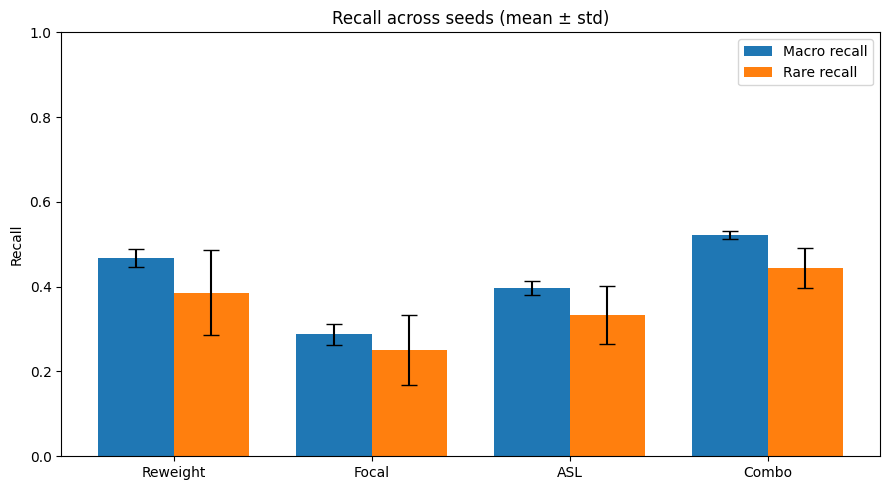

In [28]:
methods = ["Reweight", "Focal", "ASL", "Combo"]

macro_means = [np.mean(macro_rw), np.mean(macro_focal), np.mean(macro_asl), np.mean(macro_combo)]
macro_stds  = [np.std(macro_rw),  np.std(macro_focal),  np.std(macro_asl),  np.std(macro_combo)]

rare_means  = [np.mean(rare_rw),  np.mean(rare_focal),  np.mean(rare_asl),  np.mean(rare_combo)]
rare_stds   = [np.std(rare_rw),   np.std(rare_focal),   np.std(rare_asl),   np.std(rare_combo)]

x = np.arange(len(methods))
width = 0.38

fig, ax = plt.subplots(figsize=(9, 5))

ax.bar(x - width/2, macro_means, width, yerr=macro_stds, capsize=6, label="Macro recall")
ax.bar(x + width/2, rare_means,  width, yerr=rare_stds,  capsize=6, label="Rare recall")

ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylabel("Recall")
ax.set_title("Recall across seeds (mean ± std)")
ax.set_ylim(0, 1.0)
ax.legend()

plt.tight_layout()
plt.show()


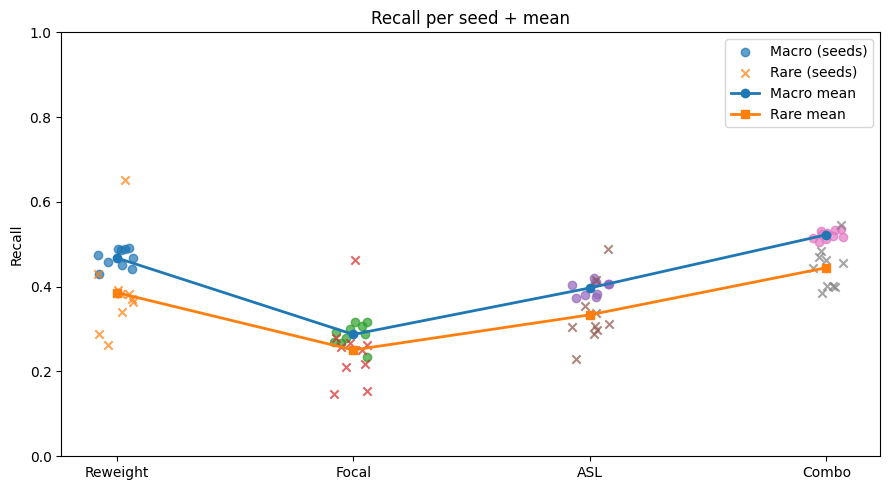

In [29]:

methods = ["Reweight", "Focal", "ASL", "Combo"]
macro_lists = [macro_rw, macro_focal, macro_asl, macro_combo]
rare_lists  = [rare_rw,  rare_focal,  rare_asl,  rare_combo]

x = np.arange(len(methods))

fig, ax = plt.subplots(figsize=(9, 5))

# jittered scatter
rng = np.random.default_rng(0)
for i in range(len(methods)):
    jitter = rng.uniform(-0.08, 0.08, size=len(macro_lists[i]))
    ax.scatter(np.full(len(macro_lists[i]), x[i]) + jitter, macro_lists[i], alpha=0.7, label="Macro (seeds)" if i==0 else None)
    ax.scatter(np.full(len(rare_lists[i]),  x[i]) + jitter,  rare_lists[i],  alpha=0.7, marker="x", label="Rare (seeds)" if i==0 else None)

# mean markers
macro_means = [np.mean(v) for v in macro_lists]
rare_means  = [np.mean(v) for v in rare_lists]
ax.plot(x, macro_means, marker="o", linewidth=2, label="Macro mean")
ax.plot(x, rare_means,  marker="s", linewidth=2, label="Rare mean")

ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylabel("Recall")
ax.set_title("Recall per seed + mean")
ax.set_ylim(0, 1.0)
ax.legend()

plt.tight_layout()
plt.show()


In [30]:
def rw_focal_asl_loss_with_logits(
    logits: torch.Tensor,
    targets: torch.Tensor,
    *,
    pos_weight: torch.Tensor | None = None,
    gamma_pos: float = 0.0,
    gamma_neg: float = 4.0,
    clip: float = 0.05,
    eps: float = 1e-8,
    reduction: str = "mean",
) -> torch.Tensor:

    if logits.shape != targets.shape:
        raise ValueError(f"logits and targets must have same shape, got {logits.shape} vs {targets.shape}")

    y = targets.to(dtype=logits.dtype, device=logits.device)

    # probabilities
    p = torch.sigmoid(logits)
    p_pos = p
    p_neg = 1.0 - p

    if clip and clip > 0.0:
        p_neg = (p_neg + clip).clamp(max=1.0)

    log_p_pos = torch.log(p_pos.clamp(min=eps))
    log_p_neg = torch.log(p_neg.clamp(min=eps))

    # asymmetric focusing weights
    w_pos = (1.0 - p_pos).pow(gamma_pos) if gamma_pos and gamma_pos > 0.0 else 1.0
    w_neg = (p_pos).pow(gamma_neg)        if gamma_neg and gamma_neg > 0.0 else 1.0

    # base ASL
    loss_pos = y * w_pos * log_p_pos
    loss_neg = (1.0 - y) * w_neg * log_p_neg

    # reweight positives per class
    if pos_weight is not None:
        pw = pos_weight.to(device=logits.device, dtype=logits.dtype)
        if pw.ndim == 1:
            pw = pw.view(1, -1)
        loss_pos = loss_pos * pw

    loss = -(loss_pos + loss_neg)

    if reduction == "none":
        return loss
    if reduction == "sum":
        return loss.sum()
    if reduction == "mean":
        return loss.mean()

    raise ValueError(f"Invalid reduction='{reduction}'. Use 'mean', 'sum', or 'none'.")


In [31]:
model_comb = SimpleMLP(X_tr.shape[1], K)
optimizer_comb = torch.optim.Adam(model_comb.parameters(), lr=1e-3)

train_model(
    model=model_comb,
    optimizer=optimizer_comb,
    loss_fn=lambda z, y: rw_focal_asl_loss_with_logits(
        z, y,
        pos_weight=pos_weight,
        gamma_pos=0.0,
        gamma_neg=4.0,
        clip=0.05
    ),
    X_tr=X_tr,
    Y_tr=Y_tr,
    n_epochs=n_epochs,
    label="Combined (RW + Focal + ASL)"
)


recall_comb = compute_per_class_recall(model_comb, X_te, Y_te)

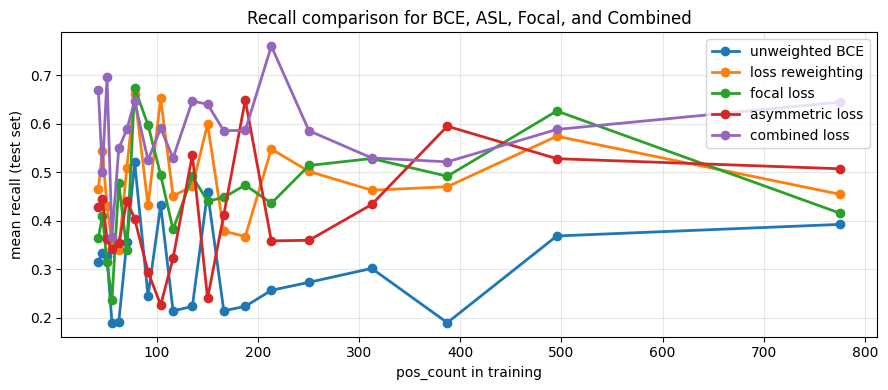

In [32]:
plot_recall_comparison(
    pos_count_tr,
    {
        "unweighted BCE": recall_unw,
        "loss reweighting": recall_w,
        "focal loss": recall_focal_w,
        "asymmetric loss": recall_asl,
        "combined loss": recall_comb
    },
    title="Recall comparison for BCE, ASL, Focal, and Combined"
)